In [115]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
% matplotlib inline

import nengo
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import norm_spa_vecs

In [116]:
def numpy_bytes_to_str(lst):
    return [l.decode('utf-8') for l in lst]

In [117]:
with h5py.File("../data/meg_ia_full.h5py", "r") as fi:
    print(list(fi.keys()))
    inp = np.array(fi['input'])
    #output = np.array(fi['output'])
    
    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])
    
    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    D = fi['vocab_vectors'].attrs['dimensions']
    
    #accum = np.array(fi['accum'])
    clean = np.array(fi['clean'])
    clean_accum = np.array(fi['clean_accum'])
    #de_out = np.array(fi['de_out'])

    dt = fi['t_range'].attrs['dt']
    t_range = np.arange(fi['t_range'][0], fi['t_range'][1], dt)
    t_pause = fi['t_range'].attrs['t_pause']
    t_present = fi['t_range'].attrs['t_present']

['clean', 'clean_accum', 'correct', 'fan1', 'fan2', 'foil1', 'foil2', 'input', 't_range', 'vocab_strings', 'vocab_vectors']


In [118]:
t_each = t_pause + t_present

In [119]:
vocab = spa.Vocabulary(D)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

In [120]:
fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

In [132]:
fan1_win = slice(int(t_pause / dt), int((len(fan1) * t_each + t_pause) / dt))
fan2_win = slice(fan1_win.stop, fan1_win.stop + int((len(fan2) * t_each) / dt))
foil1_win = slice(fan2_win.stop, fan2_win.stop + int((len(foil1) * t_each) / dt))
foil2_win = slice(foil1_win.stop, foil1_win.stop + int((len(foil2) * t_each) / dt  - dt))

wins = (fan1_win, fan2_win, foil1_win, foil2_win)

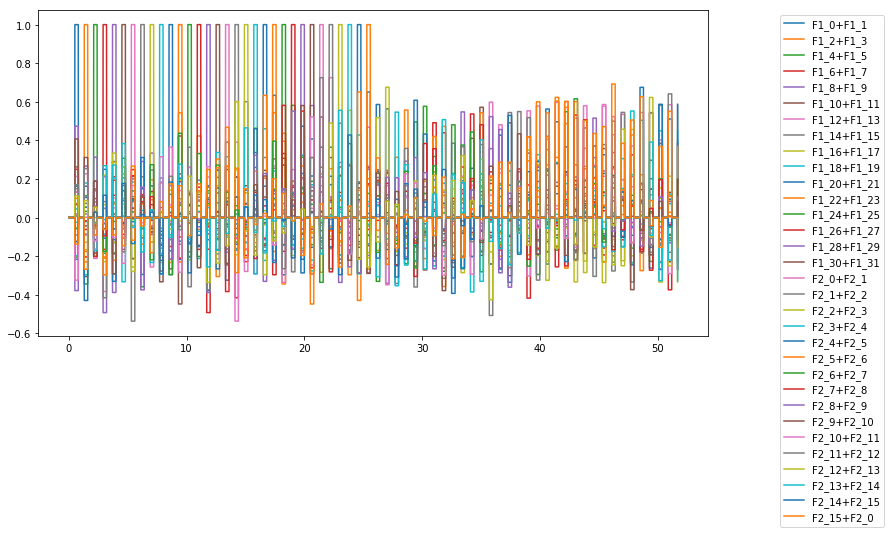

In [133]:
plt.figure(figsize=(12, 6))
plt.plot(t_range, spa.similarity(inp, fan1_pair_vecs+fan2_pair_vecs))
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

(51700, 32)


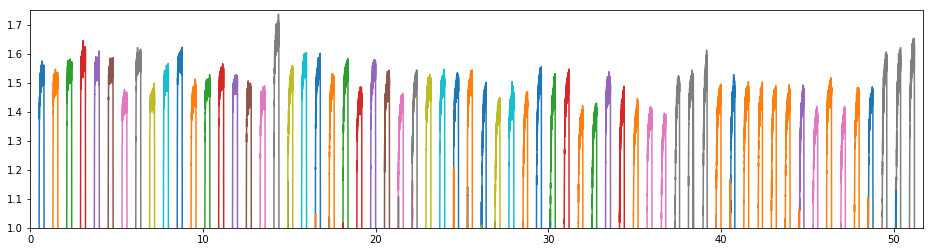

In [134]:
plt.figure(figsize=(16, 4))
plt.plot(t_range, clean_accum)
plt.ylim(1.0, 1.75)
plt.xlim(0, t_range[-1])
print(clean_accum.shape)

(0, 51.699)

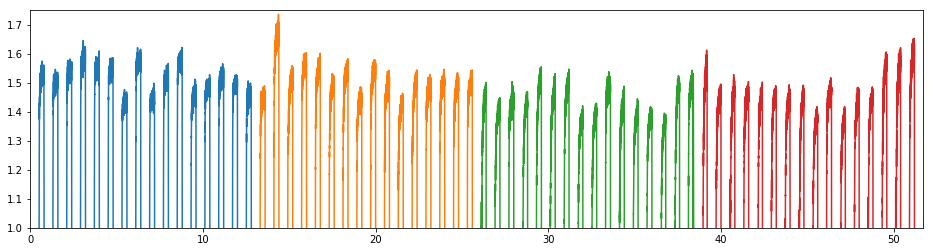

In [135]:
clean_max = np.max(clean_accum, axis=1)
plt.figure(figsize=(16, 4))
for win in wins:
    plt.plot(t_range[win], clean_max[win])
plt.ylim(1.0, 1.75)
plt.xlim(0, t_range[-1])

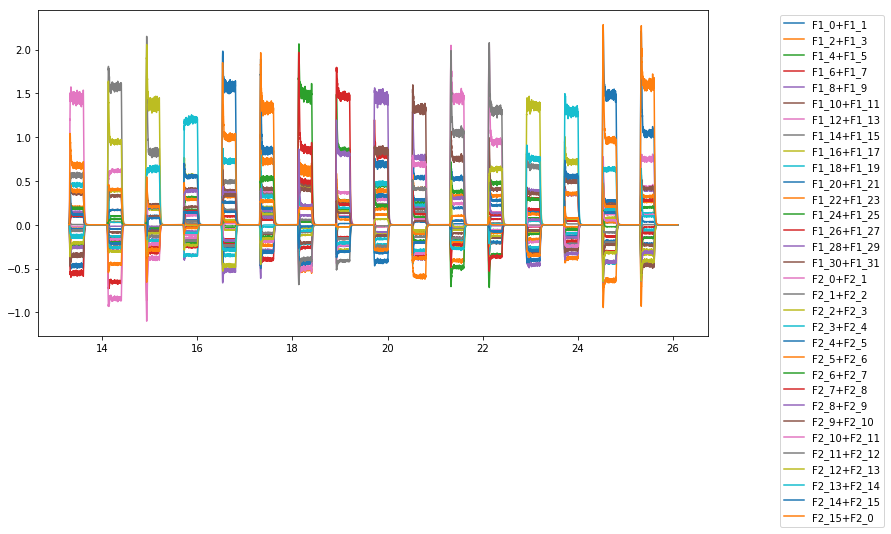

In [136]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[fan2_win], spa.similarity(clean, fan1_pair_vecs+fan2_pair_vecs)[fan2_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

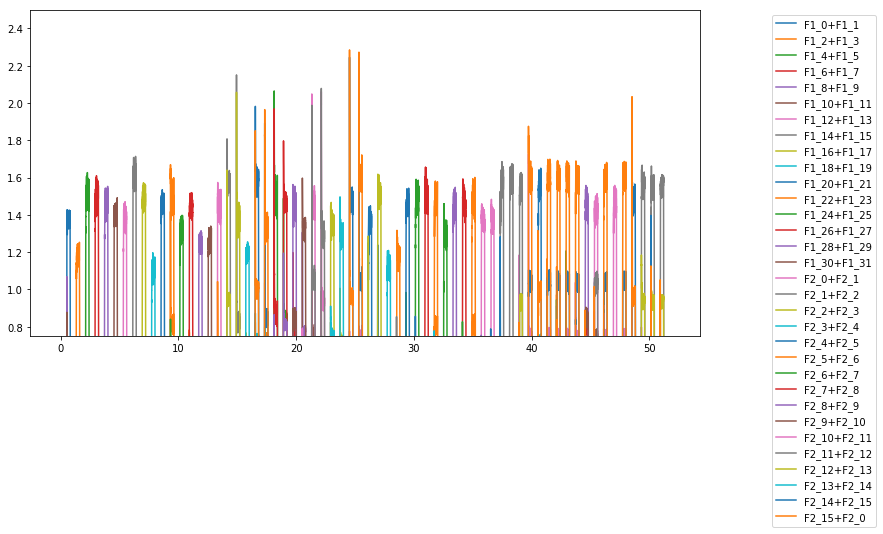

In [137]:
plt.figure(figsize=(12, 6))
plt.plot(t_range, spa.similarity(clean, fan1_pair_vecs+fan2_pair_vecs))
plt.ylim(0.75, 2.5)
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

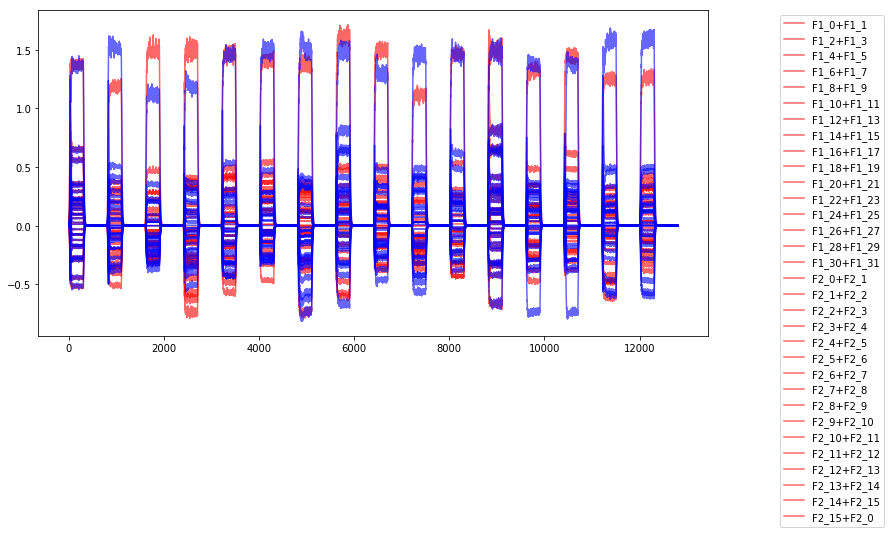

In [138]:
plt.figure(figsize=(12, 6))
plt.plot(spa.similarity(clean[fan1_win], fan1_pair_vecs+fan2_pair_vecs), alpha=0.6, color='r')
plt.plot(spa.similarity(clean[foil1_win], fan1_pair_vecs+fan2_pair_vecs), alpha=0.6, color='b')
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

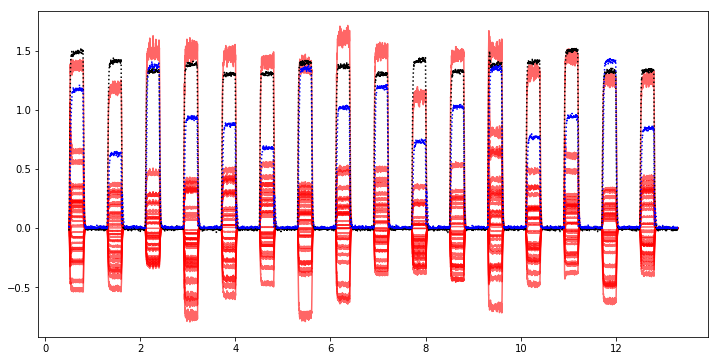

In [139]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[fan1_win], spa.similarity(clean[fan1_win], fan1_pair_vecs+fan2_pair_vecs), alpha=0.6, color='r')
plt.plot(t_range[fan1_win], clean_out[fan1_win], color='k', linestyle=':')
plt.plot(t_range[fan1_win], np.abs(noise_out[fan1_win]), color='b', linestyle=':')

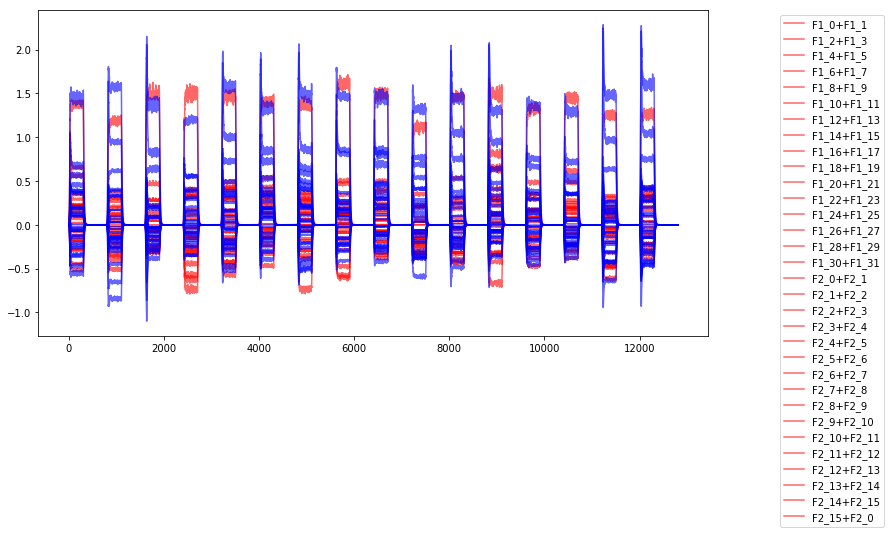

In [140]:
plt.figure(figsize=(12, 6))
plt.plot(spa.similarity(clean[fan1_win], fan1_pair_vecs+fan2_pair_vecs), alpha=0.6, color='r')
plt.plot(spa.similarity(clean[fan2_win], fan1_pair_vecs+fan2_pair_vecs), alpha=0.6, color='b')
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

# Reaction Time

FAN1 should be faster than FAN2. Should be minimal difference between FAN and FOIL.

In [141]:
with h5py.File("../data/meg_ia_full_react.h5py", "r") as fi:
    clean_out = np.array(fi['clean_out'])

In [142]:
offset = 0.15

fan1_peak_idx = np.arange(fan1_win.start+int(offset/dt), fan1_win.stop, int(t_each/dt))
fan2_peak_idx = np.arange(fan2_win.start+int(offset/dt), fan2_win.stop, int(t_each/dt))
foil1_peak_idx = np.arange(foil1_win.start+int(offset/dt), foil1_win.stop, int(t_each/dt))
foil2_peak_idx = np.arange(foil2_win.start+int(offset/dt), foil2_win.stop, int(t_each/dt))

peak_indices = (fan1_peak_idx, fan2_peak_idx, foil1_peak_idx, foil2_peak_idx)

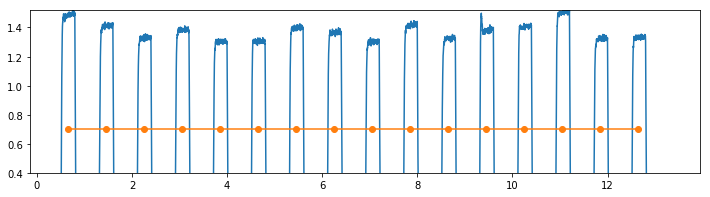

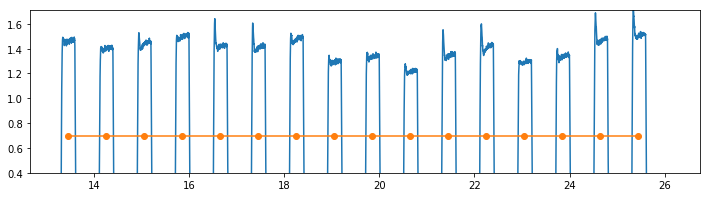

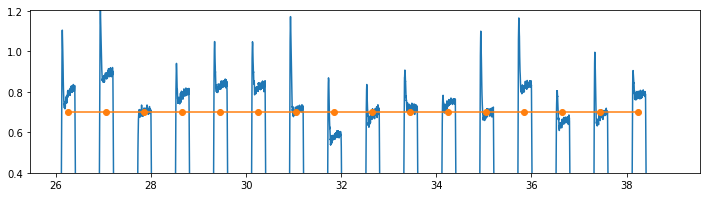

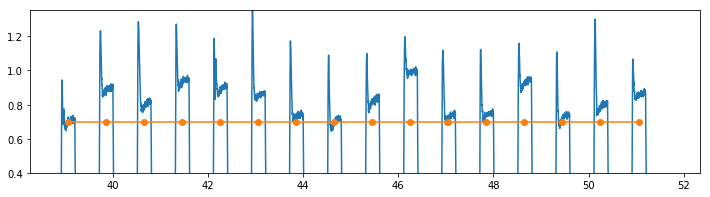

In [145]:
for win, peak_idx in zip(wins, peak_indices):
    plt.figure(figsize=(12, 3))
    plt.plot(t_range[win], clean_out[win])
    peaks = t_range[peak_idx]
    plt.plot(peaks, np.ones(peaks.shape)*0.7, linestyle=None, marker='o')
    plt.ylim(0.4, np.max(clean_out[win]))

1.3705241616846129
1.392866649070743
0.741347122365337
0.8137769765315279


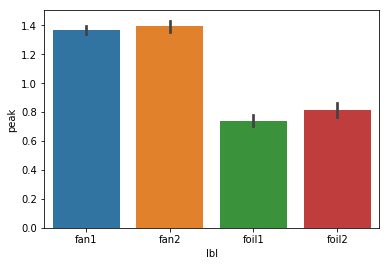

In [146]:
labels = ("fan1", "fan2", "foil1", "foil2")

pk_list = []
peak_lbl = []
for lbl, idx in zip(labels, peak_indices):
    print(np.mean(clean_out[idx]))
    pk_list.append(clean_out[idx])
    peak_lbl.extend([lbl] * len(idx))

all_peaks = np.concatenate(pk_list, axis=0).flatten()

pd_peak = pd.DataFrame({"peak": all_peaks, "lbl": peak_lbl})
sns.barplot(x="lbl", y="peak", data=pd_peak)

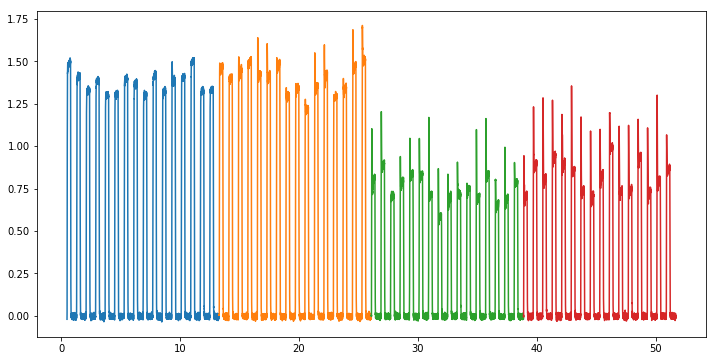

In [149]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[fan1_win], clean_out[fan1_win])
plt.plot(t_range[fan2_win], clean_out[fan2_win])
plt.plot(t_range[foil1_win], clean_out[foil1_win])
plt.plot(t_range[foil2_win.start:foil2_win.stop], clean_out[foil2_win])

# Error Rate

FAN1 should be more accurate than FAN2. Should be no difference between FAN and FOIL.